In [2]:
using Revise
using Bilevel

using RigidBodyDynamics
using MeshCatMechanisms
using MeshCat
using Plots
using LinearAlgebra
using StaticArrays
using BenchmarkTools

# Simulation of sliding box

In [69]:
urdf = joinpath("..", "..", "urdf", "ball2d.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 1.)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles);

In [ ]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf))
open(mvis)

In [131]:
N = 15
Δt = 0.05
q0 = [0., -0.1, 0.]
v0 = [5., 0., 0.];

In [ ]:
# Indirect

sim_data = get_sim_data_indirect(mechanism,env,Δt)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
sim_indirect = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

In [36]:
@benchmark sim_indirect = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

BenchmarkTools.Trial: 
  memory estimate:  6.70 MiB
  allocs estimate:  56316
  --------------
  minimum time:     9.774 ms (0.00% GC)
  median time:      10.072 ms (0.00% GC)
  mean time:        12.261 ms (16.34% GC)
  maximum time:     22.700 ms (0.00% GC)
  --------------
  samples:          408
  evals/sample:     1

In [102]:
# Direct

sim_data = get_sim_data_direct(mechanism,env,Δt)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
sim_direct = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

(Array{Float64,1}[[0.0, 0.0, 0.0], [0.225981, -0.000507223, 0.0], [0.426947, -0.000528203, 0.0], [0.603346, -0.000518581, 0.0], [0.755192, -0.000517749, 0.0], [0.882413, -0.000517913, 0.0], [0.985109, -0.000517937, 0.0], [1.06328, -0.000517935, 0.0], [1.11693, -0.000517934, 0.0], [1.14605, -0.000517935, 0.0], [1.15064, -0.000517935, 0.0], [1.15064, -0.000517935, 0.0], [1.15064, -0.000517935, 0.0], [1.15064, -0.000517935, 0.0], [1.15064, -0.000517935, 0.0]], Array{Float64,1}[[5.0, 0.0, 0.0], [4.51962, -0.0101445, 0.0], [4.01932, -0.000419612, 0.0], [3.52797, 0.000192449, 0.0], [3.03692, 1.66388e-5, 0.0], [2.54442, -3.29197e-6, 0.0], [2.05392, -4.80289e-7, 0.0], [1.56342, 4.82175e-8, 0.0], [1.07292, 1.19277e-8, 0.0], [0.582419, -5.03852e-10, 0.0], [0.0919186, -2.6753e-10, 0.0], [-2.38095e-7, -6.44817e-13, 0.0], [-2.38095e-7, -6.44817e-13, 0.0], [-2.38095e-7, -6.44817e-13, 0.0], [-2.38095e-7, -6.44817e-13, 0.0]], Array{Float64,1}[], Array{Float64,1}[], Array{Float64,1}[], [0.0, 0.05, 0.1,

In [38]:
@benchmark sim_direct = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

BenchmarkTools.Trial: 
  memory estimate:  5.32 MiB
  allocs estimate:  20913
  --------------
  minimum time:     9.331 ms (0.00% GC)
  median time:      9.557 ms (0.00% GC)
  mean time:        11.551 ms (15.05% GC)
  maximum time:     31.911 ms (22.74% GC)
  --------------
  samples:          433
  evals/sample:     1

In [ ]:
setanimation!(mvis, sim_indirect[6], sim_indirect[1])

In [ ]:
setanimation!(mvis, sim_direct[6], sim_direct[1])

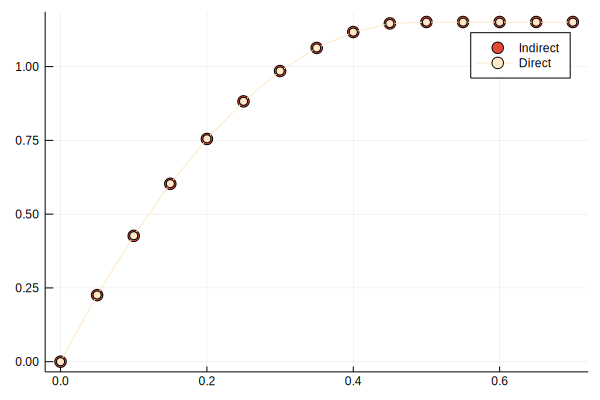

In [103]:
j = 1
plot(sim_indirect[6],sim_indirect[8][j,:],label="Indirect",seriescolor=RGB(((227,74,51) ./ 255.)...),linewidth=0,marker=6)
plot!(sim_direct[6],sim_direct[8][j,:],label="Direct",seriescolor=RGB(((254,232,200) ./ 255.)...),linewidth=1,marker=4)

In [104]:
sim_indirect[1][end]

3-element Array{Float64,1}:
 1.151124999999996
 0.0              
 0.0              

# Trajectory optimization of sliding box

In [105]:
urdf = joinpath("..", "..", "urdf", "ball2d.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 1.)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles);

In [ ]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf))
open(mvis)

In [128]:
q1 = [0., 0., 0.]
qN = [1.15, 0., 0.]
N = 15
Δt = 0.05

q_min = [-5., -5., -2*pi]
q_max = [5., 5., 2*pi]

function get_prob_limits(sim_data)
    x_min = -1e19*ones(sim_data.vs.num_vars)
    x_max = 1e19*ones(sim_data.vs.num_vars)
    
    # joint limits
    add_box_con_snopt!(x_min, x_max, sim_data, :q, q_min, q_max, 1:N)
    add_box_con_snopt!(x_min, x_max, sim_data, :h, [Δt], [Δt], 1:N-1)
    
    # torques limits
    add_box_con_snopt!(x_min, x_max, sim_data, :u, zeros(num_velocities(mechanism)), zeros(num_velocities(mechanism)), 1:N-1)

    x_min, x_max
end

function add_prob_constraints!(sim_data)
    vs = sim_data.vs

    add_eq!(sim_data, :cq1, length(q1), x -> vs(x, :q1) - q1)
    add_eq!(sim_data, :cv1, 1, x -> vs(x, :v1)[2])
#     add_eq!(sim_data, :cqN, 3, x -> vs(x, Symbol("q", N)) - qN)
    add_eq!(sim_data, :cvN, 1, x -> vs(x, Symbol("v", N))[1])
end

function get_prob_init(sim_data)
    x0 = zeros(sim_data.vs.num_vars)
    for n = 1:N
        x0[sim_data.vs(Symbol("q", n))] .= n/N*(qN - q1) + q1
    end
    
    x0
end

function add_prob_obj!(sim_data)
    for n = 1:N
        add_obj!(sim_data, Symbol("v", n), x -> sim_data.vs(x, Symbol("v", n))' * sim_data.vs(x, Symbol("v", n)))
    end
end

add_prob_obj! (generic function with 1 method)

In [130]:
# Indirect
con_tol = 1e-3
obj_tol = 1e-3
max_iter = 10000

sim_data = get_trajopt_data_indirect(mechanism,env,Δt,N,relax_comp=false)
add_prob_constraints!(sim_data)
# add_prob_obj!(sim_data)
x_min, x_max = get_prob_limits(sim_data)
x0 = get_prob_init(sim_data)
traj_indirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)

The problem appears to be infeasible: nonlinear infeasibilities minimized


(Array{Float64,1}[[-8.4751e-17, -3.00059e-18, 0.0], [-1.69417e-16, -4.23129e-17, -0.215612], [-6.49804e-17, 9.71837e-21, -0.431224], [1.46544e-16, -2.01562e-18, -0.646837], [4.23968e-18, 0.0237963, -0.862449], [0.00512874, 0.0236223, -1.07806], [0.0151949, -2.82186e-17, -1.29367], [0.0151949, 0.011851, -1.50929], [0.0202856, 5.13982e-17, -1.7249], [0.0202856, -1.20943e-17, -1.94051], [0.0202856, 1.43103e-15, -2.15612], [0.0202856, -7.25622e-17, -2.37173], [0.0202856, 0.0, -2.58735], [0.0202856, 4.15335e-17, -2.80296], [0.0202856, -3.18895e-16, -3.01857]], Array{Float64,1}[[-3.07073e-8, 0.0, -4.31224], [5.8651e-15, -8.28616e-16, -4.31224], [1.84913e-15, -4.32916e-15, -4.31224], [4.19521e-15, 1.1225e-14, -4.31224], [-0.361492, 0.309665, -4.31224], [0.0516329, 0.0887237, -4.31224], [0.509749, 0.0643933, -4.31224], [-0.236674, 0.0145694, -4.31224], [0.218767, 0.137079, -4.31224], [-7.91831e-16, -1.23677e-16, -4.31224], [1.13823e-15, 3.76037e-16, -4.31224], [1.78578e-15, 1.60401e-15, -4.312

In [27]:
@benchmark traj_indirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)

BenchmarkTools.Trial: 
  memory estimate:  23.52 MiB
  allocs estimate:  231901
  --------------
  minimum time:     21.288 ms (0.00% GC)
  median time:      22.165 ms (0.00% GC)
  mean time:        22.576 ms (0.00% GC)
  maximum time:     50.629 ms (0.00% GC)
  --------------
  samples:          222
  evals/sample:     1

In [109]:
# Semidirect
con_tol = 1e-3
obj_tol = 1e-3
max_iter = 10000

sim_data = get_trajopt_data_semidirect(mechanism,env,Δt,N,relax_comp=false)
add_prob_constraints!(sim_data)
add_prob_obj!(sim_data)
x_min, x_max = get_prob_limits(sim_data)
x0 = get_prob_init(sim_data)
traj_semidirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)

Terminated after numerical difficulties: current point cannot be improved


(Array{Float64,1}[[-1.51865e-17, 0.0, 0.0], [0.242091, 2.16419e-19, -0.0147747], [0.459491, 2.13031e-19, -0.0295495], [0.652106, -7.96796e-18, -0.0443242], [0.818659, -7.37566e-17, -0.0590989], [0.959501, -1.4085e-5, -0.0738737], [1.07718, 0.0, -0.0886484], [1.17281, -2.66296e-20, -0.103423], [1.24188, -2.66287e-20, -0.118198], [1.28882, -5.32552e-20, -0.132973], [1.29476, 0.00979413, -0.147747], [1.25272, 0.0156397, -0.162522], [1.21683, 0.0292615, -0.177297], [1.18242, 0.0190571, -0.192071], [1.15, 5.54213e-5, -0.206846]], Array{Float64,1}[[5.33631, 0.0, -0.295495], [4.84195, 0.047369, -0.295495], [4.34852, 0.0881129, -0.295495], [3.85342, 0.122366, -0.295495], [3.33198, 0.149374, -0.295495], [2.81776, 0.170234, -0.295495], [2.3581, 0.186455, -0.295495], [1.92346, 0.196719, -0.295495], [1.40312, 0.240358, -0.295495], [0.970769, 0.335309, -0.295495], [0.121202, 0.790721, -0.295495], [-1.01717, 1.1203, -0.295495], [-0.524943, 1.17955, -0.295495], [-0.386169, 0.626818, -0.295495], [0.0,

In [34]:
@benchmark traj_semidirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)

BenchmarkTools.Trial: 
  memory estimate:  105.56 MiB
  allocs estimate:  641705
  --------------
  minimum time:     70.234 ms (0.00% GC)
  median time:      149.677 ms (0.00% GC)
  mean time:        173.128 ms (0.00% GC)
  maximum time:     809.472 ms (0.00% GC)
  --------------
  samples:          29
  evals/sample:     1

In [110]:
# Direct
con_tol = 1e-3
obj_tol = 1e-3
max_iter = 10000

sim_data = get_trajopt_data_direct(mechanism,env,Δt,N,relax_comp=false)
add_prob_constraints!(sim_data)
add_prob_obj!(sim_data)
x_min, x_max = get_prob_limits(sim_data)
x0 = get_prob_init(sim_data)
traj_direct = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)

Terminated after numerical difficulties: current point cannot be improved


(Array{Float64,1}[[0.0, 0.0, 0.0], [0.189614, -0.00145228, -0.105853], [0.369659, -0.00543136, -0.211706], [0.540421, -0.0127174, -0.317559], [0.702028, -0.0238058, -0.423412], [0.854415, -0.038932, -0.529265], [0.997554, -0.0572617, -0.517984], [1.13145, -0.0779947, -0.506702], [1.25616, -0.100382, -0.49542], [1.3565, -0.117387, -0.484139], [1.4205, -0.110784, -0.472857], [1.43992, -0.0715354, -0.461576], [1.40653, 0.00887247, -0.450294], [1.31237, 0.138262, -0.439012], [1.15, 0.323584, -0.427731]], Array{Float64,1}[[3.99152, 0.0, -2.11706], [3.78785, -0.184138, -2.11706], [3.58181, -0.37362, -2.11706], [3.36994, -0.562867, -2.11706], [3.14874, -0.745748, -2.11706], [2.91505, -0.915859, -2.11706], [2.67089, -1.06725, 0.225633], [2.42395, -1.18267, 0.225633], [2.17817, -1.26379, 0.225633], [1.89481, -1.07815, 0.225633], [1.41776, -0.417967, 0.225633], [0.957889, 0.523596, 0.225633], [0.546924, 1.73932, 0.225633], [0.21707, 3.2141, 0.225633], [0.0, 4.92382, 0.225633]], Array{Float64,1}[

In [39]:
@benchmark traj_direct = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)

BenchmarkTools.Trial: 
  memory estimate:  458.98 MiB
  allocs estimate:  2502974
  --------------
  minimum time:     339.732 ms (0.00% GC)
  median time:      697.416 ms (0.00% GC)
  mean time:        732.564 ms (0.00% GC)
  maximum time:     1.495 s (0.00% GC)
  --------------
  samples:          8
  evals/sample:     1

In [ ]:
setanimation!(mvis, traj_indirect[7], traj_indirect[1])

In [ ]:
setanimation!(mvis, traj_semidirect[7], traj_semidirect[1])

In [ ]:
setanimation!(mvis, traj_direct[7], traj_direct[1])

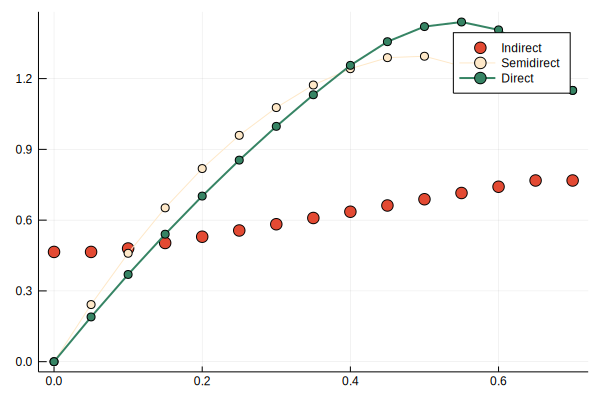

In [127]:
j = 1
plot(traj_indirect[7],traj_indirect[8][j,:],label="Indirect",seriescolor=RGB(((227,74,51) ./ 255.)...),linewidth=0,marker=6)
plot!(traj_semidirect[7],traj_semidirect[8][j,:],label="Semidirect",seriescolor=RGB(((254,232,200) ./ 255.)...),linewidth=1,marker=4)
plot!(traj_direct[7],traj_direct[8][j,:],label="Direct",seriescolor=RGB(((54,132,100) ./ 255.)...),linewidth=2,marker=4)

# Trajectory optimization of little dog

In [ ]:
urdf = joinpath("..", "..", "urdf", "little_dog", "little_dog2d.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 10.)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles);

In [ ]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf));
open(mvis)

In [ ]:
N = 8
Δt = 0.025
q0 = [0., -.275, 0., 0., 0., 0., 0., pi/4, pi/4, -pi/4, -pi/4, -pi/2, -pi/2, pi/2, pi/2] 
v0 = zeros(num_velocities(mechanism))

sim_data = get_sim_data_indirect(mechanism,env,Δt)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
traj_sim = Bilevel.simulate(sim_data,null_ctrl!,x0,N)
setanimation!(mvis, traj_sim[6], traj_sim[1])

In [ ]:
q_nom = copy(traj_sim[1][end])
q_min = min.(q_nom, [-5., -.5, -.2*pi, 0., 0., 0., 0., -3.5, -3.5, -3.5, -3.5, -3.1, -3.1, -3.1, -3.1])
q_max = max.(q_nom, [5., -0.1, .2*pi, 0., 0., 0., 0., 2.4, 2.4, 2.4, 2.4, 1., 1., 1., 1.])

x_goal = 0.1

N = 10
Δt = 0.05

function add_prob_constraints!(sim_data)
    vs = sim_data.vs

    add_eq!(sim_data, :cq1, num_positions(mechanism), x -> vs(x, :q1) - q_nom)
#     add_eq!(sim_data, :cq1, num_positions(mechanism), x -> vs(x, :q1)[1] - q_nom[1])
    add_eq!(sim_data, :cv1, num_velocities(mechanism), x -> vs(x, :v1))
    add_ineq!(sim_data, :cqNx, 1, x -> x_goal - vs(x, Symbol("q", N))[1])
#     add_eq!(sim_data, :cqNlegs, num_positions(mechanism)-1, x -> vs(x, Symbol("q", N))[2:end] - q_nom[2:end])
    add_eq!(sim_data, :cqNlegs, num_positions(mechanism)-1, x -> vs(x, Symbol("q", N))[2:end] - vs(x, :q1)[2:end])
    add_eq!(sim_data, :cvN, num_velocities(mechanism), x -> vs(x, Symbol("v", N)))

#     for n = 1:N
#         add_eq!(sim_data, Symbol("cq1", n), 2, x -> vs(x, Symbol("q", n))[8:9] + vs(x, Symbol("q", n))[11:-1:10])
#         add_eq!(sim_data, Symbol("cq2", n), 2, x -> vs(x, Symbol("q", n))[12:13] + vs(x, Symbol("q", n))[15:-1:14])
#     end
end

function add_prob_obj!(sim_data)
    for n = 1:N-1
        add_obj!(sim_data, Symbol("u", n), x -> sim_data.vs(x, Symbol("u", n))' * sim_data.vs(x, Symbol("u", n)))
    end
end

function get_prob_limits(sim_data)
    x_min = -1e19*ones(sim_data.vs.num_vars)
    x_max = 1e19*ones(sim_data.vs.num_vars)
    
    # joint limits
    add_box_con_snopt!(x_min, x_max, sim_data, :q, q_min, q_max, 1:N)
    add_box_con_snopt!(x_min, x_max, sim_data, :h, [1. * Δt], [1. * Δt], 1:N-1)
    
    # torques limits
    u_limit = 1.
    add_box_con_snopt!(x_min, x_max, sim_data, :u, -u_limit * ones(num_velocities(mechanism)), u_limit * ones(num_velocities(mechanism)), 1:N-1)
    
    x_min, x_max
end

function get_prob_init(sim_data)
    x0 = zeros(sim_data.vs.num_vars)
    for n = 1:N
        qn = copy(q_nom)
        qn[1] = (n/N)*(x_goal - q_nom[1]) + q_nom[1]
        x0[sim_data.vs(Symbol("q", n))] .= qn
    end
    
    x0
end

function setup_prob!(sim_data)
    add_prob_constraints!(sim_data)
    add_prob_obj!(sim_data)
    x_min, x_max = get_prob_limits(sim_data)
    x0 = get_prob_init(sim_data)
    
    x0, x_min, x_max
end

In [ ]:
# Indirect

sim_data = get_trajopt_data_indirect(mechanism,env,Δt,N,relax_comp=false)
x0, x_min, x_max = setup_prob!(sim_data);

In [ ]:
con_tol = 1e-3
obj_tol = 1e-3
max_iter = 10000

traj_indirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter);

x0 = traj_indirect[9]

setanimation!(mvis, traj_indirect[7], traj_indirect[1])

In [ ]:
setanimation!(mvis, traj_indirect[7], traj_indirect[1])

In [ ]:
t_step = traj_indirect[7]
q_step = traj_indirect[1]
u_step = traj_indirect[2][2:end];

In [ ]:
# Semidirect

sim_data = get_trajopt_data_semidirect(mechanism,env,Δt,N,relax_comp=false)
x0, x_min, x_max = setup_prob!(sim_data);

In [ ]:
con_tol = 1e-3
obj_tol = 1e-3
max_iter = 10000

traj_semidirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)

x0 = traj_semidirect[9]

setanimation!(mvis, traj_semidirect[7], traj_semidirect[1])

In [ ]:
setanimation!(mvis, traj_semidirect[7], traj_semidirect[1])

In [ ]:
t_step = traj_semidirect[7]
q_step = traj_semidirect[1]
u_step = traj_semidirect[2][2:end];

In [ ]:
# Direct

sim_data = get_trajopt_data_direct(mechanism,env,Δt,N,relax_comp=false)
x0, x_min, x_max = setup_prob!(sim_data);

In [ ]:
con_tol = 1e-3
obj_tol = 1e-3
max_iter = 10000

traj_direct = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)

x0 = traj_direct[9]

setanimation!(mvis, traj_direct[7], traj_direct[1])

In [ ]:
setanimation!(mvis, traj_direct[7], traj_direct[1])

In [ ]:
t_step = traj_direct[7]
q_step = traj_direct[1]
u_step = traj_direct[2][2:end];

In [ ]:
# Multi-steps

reps = 5

ttraj = t_step
qtraj = q_step
utraj = u_step
for i = 1:(reps-1)
    ttraj = vcat(ttraj, t_step .+ ttraj[end])
    qtraj = vcat(qtraj, map(q -> q + vcat(qtraj[end][1],zeros(length(q)-1)), q_step))
    utraj = vcat(utraj, u_step)
end

setanimation!(mvis, ttraj, qtraj)